### In this notebook:
#### Functions to eliminate duplicates that happen when the HIPPARCOS and GAIA star catalogs get combined

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.ascii as a
import astropy.table
import FunctionsToLoadGaia as load
import FunctionsForGaia as F
from math import pi
from astropy.coordinates import SkyCoord

#### Extraction RA and Dec (and distance?) from each Tgas file and then combinign them in a large file that will serve to compare GAIA to Hipparcos. Can't use the same combined file of GAIA data we used previously because RA and DEC got turned to X,Y,Z coordinates.

In [2]:
def findGalactic(filename):
    """ 
    This formula extracts arrays of right ascension and declinaton.
    for each star. Right ascecsion values are set to range from -180º 
    to 180º.
    Both declination and right ascencion arrays are turned from degrees
    to radians. 
    The distance is calculated from the parallax.
    RA,DEC and distance are then used to calculate the galactic latitude and longitude of each star.
    RA, Dec, distance, galactic latitude and galactic longitude are returned. 
    """
    
    hdu = astropy.io.fits.open(filename)
    table = astropy.table.Table(hdu[1].data)
    dec = (table['dec'].data)*(pi/180) #change degrees to radians.
    
    RA = (table['ra'].data)
    over180 = RA > 180 #want RA values to be from -180 to 180
    RA[over180] = (RA[over180] - 360)
    ra = RA*(pi/180) #change degrees to radians.
    
    Parallax= table['parallax'].data
    Parallax = Parallax/1000 # ZKBT: the GAIA parallaxes are in units of milliarcseconds; let's convert to arcsec
    negative = Parallax<0
    Parallax[negative] = 10**(-6) #replace al negative parallaxes with 10^-6 arcseconds
    uncertainty = (table['parallax_error']/table['parallax']) > 0.5
    Parallax[uncertainty] = 10**(-6) #replace all parallaxes with uncertainty greater than 50% with 10^-6 arcseconds
    distance = F.ParallaxToDistance(Parallax)
    

    c = SkyCoord(ra,dec,frame='icrs',unit='rad')
    longitude = c.galactic.l.rad
    overPi= longitude >np.pi
    longitude[overPi]-=2*np.pi
    latitude = c.galactic.b.rad


    return ra, dec, distance,longitude,latitude

In [3]:
from glob import glob
filenames = glob('data/TgasSource_000-000-*.fits')

RA,DEC,Distance,Longitude,Latitude = np.array([]), np.array([]), np.array([]),np.array([]),np.array([])
for f in filenames:
    ra,dec, distance,longitude,latitude = findGalactic(f)
    RA = np.append(RA,ra)
    DEC = np.append(DEC,dec)
    Distance = np.append(Distance,distance)
    Longitude = np.append(Longitude,longitude)
    Latitude= np.append(Latitude,latitude)

gaiaGalactic=astropy.table.Table([RA,DEC,Distance,Longitude,Latitude], names=['RA','Dec','Distance','Longitude','Latitude']) #make a table that has both Ra and Dec


In [4]:
#separate each column to graph later
gaiaRa = gaiaGalactic['RA']
gaiaDec = gaiaGalactic['Dec']
gaiaLongitude = gaiaGalactic['Longitude']
gaiaLatitude=gaiaGalactic['Latitude']
gaiaDistance = gaiaGalactic['Distance']

print gaiaGalactic

       RA              Dec           Distance      Longitude        Latitude   
--------------- ----------------- -------------- -------------- ---------------
 0.785997341115  0.00410835930241  32467559.4551  3.08470222661 -0.850227004082
 0.788278074838  0.00349183991191  52883951.5028  3.08777411686 -0.849015437717
 0.786901848987  0.00434282318118  65370627.8468  3.08540012761 -0.849414076325
 0.786559532667  0.00433209554591   89978969.807  3.08505126483 -0.849667504461
 0.787772478301  0.00584761401909  130375962.375  3.08468076696 -0.847741880531
 0.787865676997  0.00627652194242  23809637.6422  3.08431333016 -0.847376485494
 0.788067800672  0.00674295564092  36198210.0076  3.08402001325 -0.846906704869
 0.787366523381  0.00664697326872  98652952.7274  3.08338657294 -0.847476870231
 0.785577400102  0.00612782915085  33255149.8166  3.08206434227 -0.849121824911
 0.784955884679  0.00826364927436  122946931.639  3.07909433433 -0.848076106882
            ...               ...       

In [5]:
gaiaDistance.size

2057050

#### The Hipparcos catalog has stars positions saved as X,Y,Z coodrinates. Have to  turn these back into RA and DEC. 

In [28]:
def toGalacticCoordinates (X,Y,Z):
    """
    This function converts X,Y and Z coordinates into
    Right ascenceion, declination and distance for each star of the set
    
    Parameters: 
    ------------------------------------------
    X,Y,Z = Arrays of the x,y and z coordinates for a set of stars.
    
    Returns:
    ------------------------------------------
    RA = array of the right ascencion of each star.
    Dec = array of the declination of each star. 
    Distances = array of the distances to each star. 
    
    """
   
    # lets convert them to GALACTIC latitude and longitude
    distance = np.sqrt(X**2 + Y**2 + Z**2)

    # this GALACTIC longitude is 0 at the center of the galaxy 
    galactic_longitude = np.arctan2(Y, X)      # in radians

    # GALACTIC latitude is 0 along the galactic equator
    galactic_latitude = np.arcsin(Z/distance)  # in radians
    galactic_latitude[0] = 0

    # we can use astropy to create a SkyCoord object containing these positions
    coord = SkyCoord(galactic_longitude, galactic_latitude, frame='galactic', unit='rad')
    
    # RA and Dec are the CELESTIAL system
    celestial_longitude = coord.icrs.ra.rad # in radians
    celestial_latitude = coord.icrs.dec.rad # in radians
    RA=celestial_longitude
    dec = celestial_latitude
    
    over2pi = RA > np.pi #want RA values to be from -pi to pi
    RA[over2pi] = (RA[over2pi] - 2*np.pi)
    ra = RA
    
    longitude = galactic_longitude
    latitude = galactic_latitude
    
    return ra, dec, distance,longitude,latitude

In [29]:
original = astropy.io.ascii.read('data/starshp.dat', 
                            data_start=33,
                            names=['ID', 'X', 'Y', 'Z', 'DX', 'DY', 'DZ', 'BV', 'AbsMag'])

HipX = original['X']
HipY = original['Y']
HipZ = original['Z']

hippRa, hippDec, hippDistance,hippLongitude,hippLatitude = toGalacticCoordinates(HipX,HipY,HipZ)

hippGalactic=astropy.table.Table([hippRa,hippDec,hippDistance,hippLongitude,hippLatitude], names=['RA','Dec','Distance','Longitude','Latitude']) #make a table that has both Ra and Dec
print hippGalactic

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide


        RA               Dec        ...    Longitude        Latitude    
----------------- ----------------- ... --------------- ----------------
   -1.63354111784   -0.505031574886 ...             0.0              0.0
1.56403842215e-05   0.0190067404563 ...   1.69621427761   -1.03301305049
7.43100415281e-05   -0.340318912418 ...   1.10159984506   -1.32572348434
8.75028413558e-05    0.678222282789 ...   1.95634020902  -0.400161573313
0.000150629781791   -0.905713275441 ... -0.684294998509   -1.10680712166
0.000173990103705   -0.708450220825 ... -0.385756198557   -1.27167634379
0.000326125414462   0.0688785397096 ...   1.73170232462  -0.986844566069
0.000384366439616    0.349695742663 ...   1.86435033231  -0.719486226329
0.000476441447119     0.45180409804 ...   1.89739784661  -0.620709503257
0.000616325145657    0.638545381211 ...   1.94737728429  -0.438987370092
              ...               ... ...             ...              ...
  -0.767603136332   -0.101631532723 ...  0.76206321

In [ ]:
#separate each column to use on the graph
hippRa = hippGalactic['RA']
hippDec = hippGalactic['Dec']
hippDistance = hippGalactic['Distance']
hippLongitude = hippGalactic['Longitude']
hippLatitude = hippGalactic['Latitude']


#### now to find the duplicates. The following function will determine if the nth star is a duplicate. 
#### having a list of these duplicates I hope it is easier to eliminate them from the master list... 

In [10]:
def findDuplicates(hippRaDec,gaiaRaDec):
    """
    This function will go over the arrrays of stars from the HIPPARCOS and GAIA
    catalogs and determine which stars are duplicates
    
    Parameters:
    ----------------------------------
    GaiaRaDec = array of the RA and DEC of the GAIA catalog
    HipRaDec = array of the RA and DEC of the HIPPARCOS catalog
    
    Returns:
    -----------------------------------
    duplicates = array of the 'positions' of the stars in the GAIA arrays that 
    are repeats of the HIPPARCOS catalog
    """

    duplicatesHipp= []
    duplicatesGaia=[]
    for i in range(10):#(hippRaDec)):
        
        radius = (2.0/60.0/60.0)*(np.pi/180)
        distance = np.sqrt((hippRaDec['Longitude'][i] - gaiaRaDec['Longitude'])**2 + (hippRaDec['Latitude'][i] - gaiaRaDec['Latitude'])**2 )
        
        threshold = radius 
        match = distance<threshold
        
#        print i,np.sum(match)

        row=np.nonzero(match)[0]
        if len(row)==0:
            continue
        if len(row)==1:       
            duplicatesHipp = np.append(duplicatesHipp,i)
            duplicatesGaia = np.append(duplicatesGaia,row)
     
        
    
    return duplicatesHipp, duplicatesGaia

In [13]:
duplicatesHipparcos, duplicatesGaia = findDuplicates(hippGalactic,gaiaGalactic)
print duplicatesHipparcos
print duplicatesGaia

[ 1.  3.  4.  5.]
[  747611.   770684.  1317415.   699264.]


#### In the next cells, I will create graohs that will help me determine if the above calculations are correct. 
#### If all goes well, a graph of the coordinates will show the hipparcos, Gaia and duplicates in different colors and it will be clear which stars need to be eliminated. 

<function matplotlib.pyplot.show>

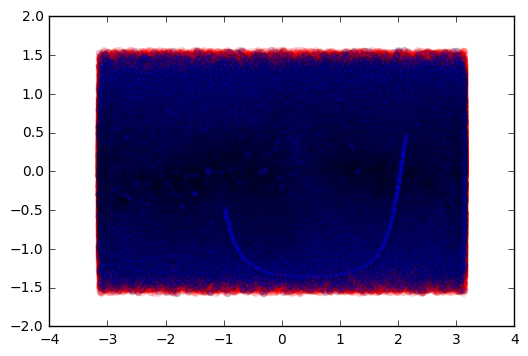

In [21]:
plt.scatter(gaiaLongitude,gaiaLatitude,alpha=0.1,color='r')
plt.scatter(hippLongitude,hippLatitude,alpha=0.1)
plt.show

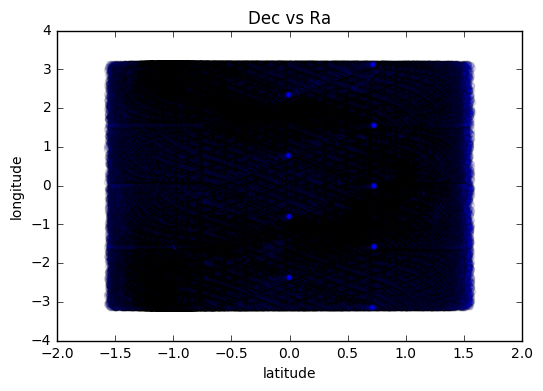

In [24]:
#plt.figure(figsize=(9,9))
plt.title('Dec vs Ra')
plt.scatter(gaiaDec,gaiaRa, alpha=0.1)
plt.xlabel('latitude')
plt.ylabel('longitude')

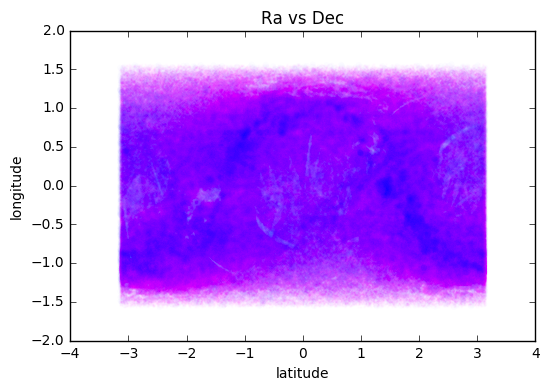

In [30]:
#plt.figure(figsize=(9,9))
plt.title('Ra vs Dec')
plt.scatter(gaiaRa,gaiaDec,color='magenta',alpha=0.01,s=0.5)
plt.scatter(hippRa,hippDec, edgecolor='none', alpha=0.01)
#plt.scatter(duplicatesRa,duplicatesDec,color='cyan',alpha=0.1)

plt.xlabel('latitude')
plt.ylabel('longitude')

In [19]:
plt.scatter(gaiaDistance,gaiaDec,color='cyan')


#### The most important thing accomplished above is the list of nth positions that a re duplicates.
#### This very important function below will be transfered to a module and used on MergeHIPandGaia before the two files are merged but after the master list for GAIA has been created.


In [ ]:
def eliminateDuplicates(duplicates,Gaia):
    """
    This function eliminates the stars on the GAIA array tht are repeated on the 
    hipparcos catalog
    
    Parameters:
    ------------------------------------
    duplicates = array of the 'positions' of the duplicates in the gaia catalog
    Gaia= 
    
    Returns:
    -------------------------------------
    GaiaNoDuplicates: array of the positions of the stars from the Gaia catalog
    without the stars that HIPPARCOS already mapped
    """
    
    numpy.delete(Gaia,duplicates)
    
    return GaiaNoDuplicates

### Eliminate duplicates 2

In [ ]:
hdu = astropy.io.fits.open('data/TgasSource_000-000-004.fits')
table = astropy.table.Table(hdu[1].data)
DEC = (table['dec'].data)*(pi/180) #change degrees to radians.

ra = (table['ra'].data)
over180 = ra > 180 #want RA values to be from -180 to 180
ra[over180] = (ra[over180] - 360)
RA = ra*(pi/180) #change degrees to radians.

#RA and DEC are in radians 

Parallax= table['parallax'].data
Parallax = Parallax/1000 # ZKBT: the GAIA parallaxes are in units of milliarcseconds; let's convert to arcsec
negative = Parallax<0
Parallax[negative] = 10**(-6) #replace al negative parallaxes with 10^-6 arcseconds
uncertainty = (table['parallax_error']/table['parallax']) > 0.5
Parallax[uncertainty] = 10**(-6) #replace all parallaxes with uncertainty greater than 50% with 10^-6 arcseconds
distance = F.ParallaxToDistance(Parallax)
#Distance is in AU    



In [ ]:
radius = 2.0/60.0/60.0
for i in range(len(gaia)):
    distance = np.sqrt((original['RA'] - gaia['RA'][i])**2 + (original['DEC'] - gaia['DEC'][i])**2 )

In [ ]:
X,Y,Z,RA,Dec,Magnitudes,Distances,AbsoluteMagnitudes,Fluxes,label = load.extractStars('data/TgasSource_000-000-001.fits')
print RA

In [ ]:
c = SkyCoord(RA,Dec,frame='icrs',unit='rad')
print c
longitude = c.galactic.l.rad
latitude = c.galactic.b.rad

print longitude

print latitude